Parkinson’s Disease (PD) is a degenerative neurological disorder marked by decreased dopamine levels in the brain. It manifests itself through a deterioration of movement, including the presence of tremors and stiffness. There is commonly a marked effect on speech, including dysarthria (difficulty articulating sounds), hypophonia (lowered volume), and monotone (reduced pitch range). Additionally, cognitive impairments and changes in mood can occur, and risk of dementia is increased.


Traditional diagnosis of Parkinson’s Disease involves a clinician taking a neurological history of the patient and observing motor skills in various situations. Since there is no definitive laboratory test to diagnose PD, diagnosis is often difficult, particularly in the early stages when motor effects are not yet severe. Monitoring progression of the disease over time requires repeated clinic visits by the patient. An effective screening process, particularly one that doesn’t require a clinic visit, would be beneficial. Since PD patients exhibit characteristic vocal features, voice recordings are a useful and non-invasive tool for diagnosis. If machine learning algorithms could be applied to a voice recording dataset to accurately diagnosis PD, this would be an effective screening step prior to an appointment with a clinician.


1. name - ASCII subject name and recording number
2. MDVP:Fo(Hz) - Average vocal fundamental frequency
3. MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
4. MDVP:Flo(Hz) - Minimum vocal fundamental frequency
5. MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
6. MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
7. NHR,HNR - Two measures of ratio of noise to tonal components in the voice
8. status - Health status of the subject (one) - Parkinson's, (zero) - healthy
9. RPDE,D2 - Two nonlinear dynamical complexity measures
10. DFA - Signal fractal scaling exponent
11. spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation



The data consists of those diagnosed with Parkinson Disease and those who do not.

In [30]:
#Import all the necessary modules
import pandas as pandas
import numpy as numpy
import os
import matplotlib.pyplot as matplot
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import itertools
from IPython.display import Image  
from sklearn import tree
from os import system
from Custom import Perform_EDA as EDA
import numpy as np
import pandas as pd
from scipy.stats import levene, shapiro, f_oneway
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from Custom import Build_Model as Build_Model
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
numpy.random.seed(2345)

In [31]:
def plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True):
    cm = metrics.confusion_matrix(Y_test, Y_predict)
    accuracy = numpy.trace(cm) / float(numpy.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = matplot.get_cmap('Blues')

    matplot.figure(figsize=(8, 6))
    matplot.imshow(cm, interpolation='nearest', cmap=cmap)
    matplot.title(title)
    matplot.colorbar()

    if target_names is not None:
        tick_marks = numpy.arange(len(target_names))
        matplot.xticks(tick_marks, target_names, rotation=45)
        matplot.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            matplot.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            matplot.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    matplot.tight_layout()
    matplot.ylabel('True label')
    matplot.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    matplot.show()
    print(metrics.classification_report(Y_test, Y_predict))
    model_performance = [metrics.accuracy_score(Y_test, Y_predict),metrics.recall_score(Y_test, Y_predict),
                         metrics.precision_score(Y_test, Y_predict),metrics.f1_score(Y_test, Y_predict) ]
    accuracy_report = pandas.DataFrame(model_performance, columns=['Model_Performance'], 
                                   index=['Accuracy','Recall','Precision','f1_Score'])
    return accuracy_report

Defined set of Visualization, EDA functions for ease of analysis

In [32]:
Source = pandas.read_csv("parkinsons_data.csv")

# Understand the data set

Approach :
    
Data skimmed through to see what are the variables present, data type, shape, column names, mixed data types, missing values etc


In [33]:
Source.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [34]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

In [35]:
Source.shape

(195, 24)

In [36]:
Source["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

In [37]:
147/185

0.7945945945945946

In [38]:
Source["status"] = pandas.Categorical(Source["status"])

In [39]:
Source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null category
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null f

# Exploratory Data Analysis - Data Wrangling and Pre-processing

# Approach

1. Analyse 5 pont summary, Kurtosis, Skewness and Range
2. Analyse the distribution of the data for each variable
3. Analyse outliers using Box plot
4. Infer the results and assess the impact 
5. Perform correlation analysis and VIF to determine the relationships between X's
6. Determine the data transformation and treatment requirements like missing values, outliers, scaling etc
7. Choose the set of predictors which can be used for modelling
8. Remove outliers

In [40]:
EDA.EDA(Source)

Total Missing Values =  0.0 Data Points, Contributing to  0.0 %
Columns with values as 0

 Series([], dtype: object) 


Columns with numnber of Zeros



,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skewness,Range,IQR,Missing Values
MDVP:Fo(Hz),195.0,154.228641,41.390065,88.333000,117.572000,148.790000,182.769000,260.105000,-0.627898,0.591737,171.772000,65.197000,0.0
MDVP:Fhi(Hz),195.0,197.104918,91.491548,102.145000,134.862500,175.829000,224.205500,592.030000,7.627241,2.542146,489.885000,89.343000,0.0
MDVP:Flo(Hz),195.0,116.324631,43.521413,65.476000,84.291000,104.315000,140.018500,239.170000,0.654615,1.217350,173.694000,55.727500,0.0
MDVP:Jitter(%),195.0,0.006220,0.004848,0.001680,0.003460,0.004940,0.007365,0.033160,12.030939,3.084946,0.031480,0.003905,0.0
MDVP:Jitter(Abs),195.0,0.000044,0.000035,0.000007,0.000020,0.000030,0.000060,0.000260,10.869043,2.649071,0.000253,0.000040,0.0
MDVP:RAP,195.0,0.003306,0.002968,0.000680,0.001660,0.002500,0.003835,0.021440,14.213798,3.360708,0.020760,0.002175,0.0
MDVP:PPQ,195.0,0.003446,0.002759,0.000920,0.001860,0.002690,0.003955,0.019580,11.963922,3.073892,0.018660,0.002095,0.0
Jitter:DDP,195.0,0.009920,0.008903,0.002040,0.004985,0.007490,0.011505,0.064330,14.224762,3.362058,0.062290,0.006520,0.0
MDVP:Shimmer,195.0,0.029709,0.018857,0.009540,0.016505,0.022970,0.037885,0.119080,3.238308,1.666480,0.109540,0.021380,0.0
MDVP:Shimmer(dB),195.0,0.282251,0.194877,0.085000,0.148500,0.221000,0.350000,1.302000,5.128193,1.999389,1.217000,0.201500,0.0


Columns that are int32,int64 =  Index([], dtype='object')
Columns that are flaot32,float64 =  Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')
Columns that are objects =  Index(['name'], dtype='object')


TypeError: 'numpy.float64' object cannot be interpreted as an integer

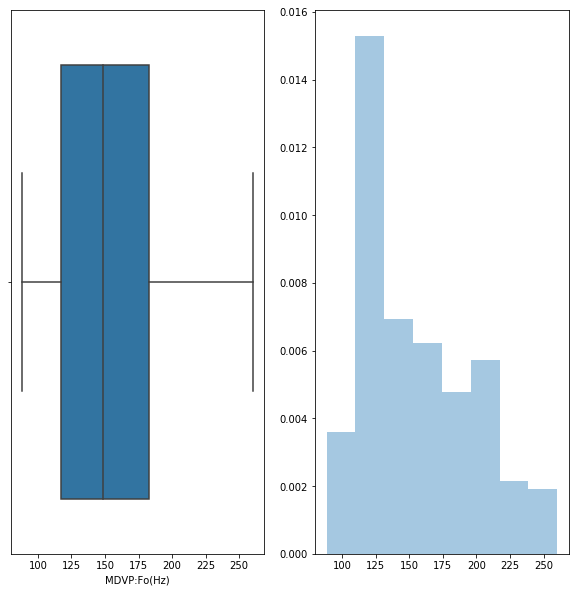

In [41]:
EDA.univariate_plots(Source)

MDVP:Fo(Hz)	:
1. Range 171.77 and Std Dev 41.39 suggests that there is a large spread of data from the median
2. Kurtosis -0.62 suggests that light tails or less data is distributed around the tails. However this is not a strong negative and hence a thin tail can be observed
3. Skewness 0.59 suggests that the data is positively skewed. The strength of the skewness is less and hence need to evaluate whether transformation (scalar or log or exp)
4. Box plot suggests that there are no outliers in the data albeit the spread is large

MDVP:Fhi(Hz)	:
1. Range 489.885 and Std Dev 91.49 suggests that there is a large spread of data from the median and the data may have outliers
2. Kurtosis 7.62 suggests that there is a heavy tail and more data points are distributed around the tail. This is evident in the box plot
3. Skewness 2.542 suggests that the data is positively skewed. The strength of the skewness is high and hence if this feature is used as predictor, transformation is required
4. Box plot suggests that there are outliers in the data and this needs treatment before building model
5. Distplot shows there is a slight bi-modal distribution indicating a possible gaussian mixture. This however is a risk that needs to be accepted for this project
6. Distplot shows that there is narrow arear where data is distributed 

MDVP:Flo(Hz) :
1. Range 173.69 and std dev 43.52 suggests that the spread of the data is large
2. Kurtosis 0.654 suggests that there is strong tail. This is evident in distribution plot and box plot
3. Skewness is 1.217 suggests that the data is positively skewed. The strength of the skewness is high & hence if this feature is used as predictor, transformation is required
4. Box plot suggests that there are outliers and this needs treatment before building model


'MDVP:Jitter(%)' :
1. Range 0.031480 and std dev 0.004848 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 12.03 is the 4th highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 3.0849 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are quite a number for this variable and is evident in box plot

'MDVP:Jitter(Abs)' :
1. Range 0.000253 and std dev 0.000035 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 10.86 is one of the highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 2.649 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are quite a number for this variable and is evident in box plot

'MDVP:RAP' :
1. Range 0.020760 and std dev 0.002968 suggests that there is a fair amount of spread of data given the scale of data points
2. Kurtosis 14.213 is the 3rd highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 3.360 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are quite a number for this variable and is evident in box plot
5. The distribution plot indicates 2 small peaks at the long tail indicating possible gaussian miture however since its small, this may or may not impact models

'MDVP:PPQ' :
1. Range 0.018660 and std dev 0.002759 suggests that the spread of the data is large
2. Kurtosis 11.963922 is one of the highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 3.073892 suggests that the data is positively skewed. The strength of the skewness is high & hence if this feature is used as predictor, transformation is required
4. Box plot suggests that there are outliers and this needs treatment before building model
5. The distribution plot indicates small peaks at the long tail indicating possible gaussian miture however since its small, this may or may not impact models

'Jitter:DDP' :
1. Range 0.062290 and std dev 0.008903 suggests that the spread of the data is large
2. Kurtosis 14.224762 is the 2nd highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 3.362058 suggests that the data is positively skewed. The strength of the skewness is high & hence if this feature is used as predictor, transformation is required
4. Box plot suggests that there are outliers and this needs treatment before building model
5. Distribution plot clearly shows the inference made through Skewness and Kurtosis, the long tail and +ve skewness is very evident

'MDVP:Shimmer' : 
1. Range 0.109540 and std dev 0.018857 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 3.238308 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is 1.666480 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are quite a number for this variable and is evident in box plot. This will have to be treated before model building

'MDVP:Shimmer(dB)' : 
1. Range 1.217000 and std dev 0.194877 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 5.128193 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is 1.999389 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are quite a number for this variable and is evident in box plot. This will have to be treated before model building

'Shimmer:APQ3' :
1. Range 0.051920 and std dev 0.010153 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 2.720152 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is 1.580576 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building

'Shimmer:APQ5' : 
1. Range 0.073700 and std dev 0.012024 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 3.874210 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is 1.798697 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building
5. The distribution plot indicates small peaks at the long tail indicating possible gaussian miture however since its small, this may or may not impact models

'MDVP:APQ' : 
1. Range 0.130590 and std dev 0.016947 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 11.163288 is one of the highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 2.618047 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building

'Shimmer:DDA' : 
1. Range 0.155780 and std dev 0.030459 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 2.720661 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is 1.580618 suggests positive skewness of data. THis is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building

'NHR' :
1. Range 0.314170 and std dev 0.040418 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 21.994974 is the highest amongst all 22 variables of the data set indicates a strong tail or large data distribution around the tail. This needs treatment
3. Skewness is 4.220709 is the highest amongst all 22 variables shows strong positive skewness of data. THis is evident in distribution plot and box plot.
   Data transformation is required to handle this skewness
4. This variables has quite a lot of outliers and this will have to treated before model building

'HNR' :
1. Range 24.606000 and std dev 4.425764 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 0.616036 shows there is a small tail or data is distributed along the tail. Though this is small it requires treatment
3. Skewness is -0.514317 suggests negative skewness of data. This is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building
5. The distribution of data shows a small double peak indicating a possible gaussian mixture. This however is a risk that needs to be accepted for this project

'RPDE' :
1. Range 0.428581 and std dev 0.103942 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis -0.921781 suggests light tails or less data is distributed around the tails. However this is not a strong negative and hence a thin tail can be observed
3. Skewness is -0.143402 suggests negative skewness of data. This is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. Boxplot shows there are no outliers and hence no special treatment required
5. The distribution of data shows a  double peak indicating a possible gaussian mixture. This however is a risk that needs to be accepted for this project

'DFA' : 
1. Range 0.251006 and std dev 0.055336 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis -0.686152 suggests light tails or less data is distributed around the tails. However this is not a strong negative and hence a thin tail can be observed
3. Skewness is -0.033214 suggests negative skewness of data. This is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. Boxplot shows there are no outliers and hence no special treatment required
5. The distribution of data shows a  double peak indicating a possible gaussian mixture. This however is a risk that needs to be accepted for this project

'spread1' :
1. Range 5.530953 and std dev 1.090208 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis 0.050199 suggests light tails or less data is distributed around the tails. However this is not a strong negative and hence a thin tail can be observed
3. Skewness is 0.432139 suggests positive skewness of data. This is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building
5. The distribution of data shows a a good symmetry when compared. 

'spread2' :
1. Range 0.444219 and std dev 0.083406 suggests that there is a wide spread of data given the scale of data points
2. Kurtosis -0.083023 suggests light tails or less data is distributed around the tails. However this is not a strong negative and hence a thin tail can be observed
3. Skewness is 0.144430 suggests positive skewness of data. This is evident in distribution plot and box plot. Data transformation is required to handle this skewness
4. The outliers are two data point for this variable and is evident in box plot. This will have to be treated before model building
5. The distribution of data shows a a good symmetry when compared. 

'D2' : 
1. Range 2.247868 and Std Dev 0.382799 suggests that there is a large spread of data from the median and the data may have outliers
2. Kurtosis 0.220334 suggests that there is a heavy tail and more data points are distributed around the tail. This is evident in the box plot
3. Skewness 0.430384 suggests that the data is positively skewed. The strength of the skewness is high and hence if this feature is used as predictor, transformation is required
4. The outliers is only one data point for this variable and is evident in box plot. This will have to be treated before model building
5. The distribution of data shows a a good symmetry when compared. 

'PPE' :
1. Range 0.482828 and Std Dev 0.090119 suggests that there is a large spread of data from the median and the data may have outliers
2. Kurtosis 0.528335 suggests that there is a heavy tail and more data points are distributed around the tail. This is evident in the box plot
3. Skewness 0.797491 suggests that the data is positively skewed. The strength of the skewness is high and hence if this feature is used as predictor, transformation is required
4. The outliers are few for this variable and is evident in box plot. This will have to be treated before model building

The features are of different scales and hence normalization - scalar, log or exp may have to be done

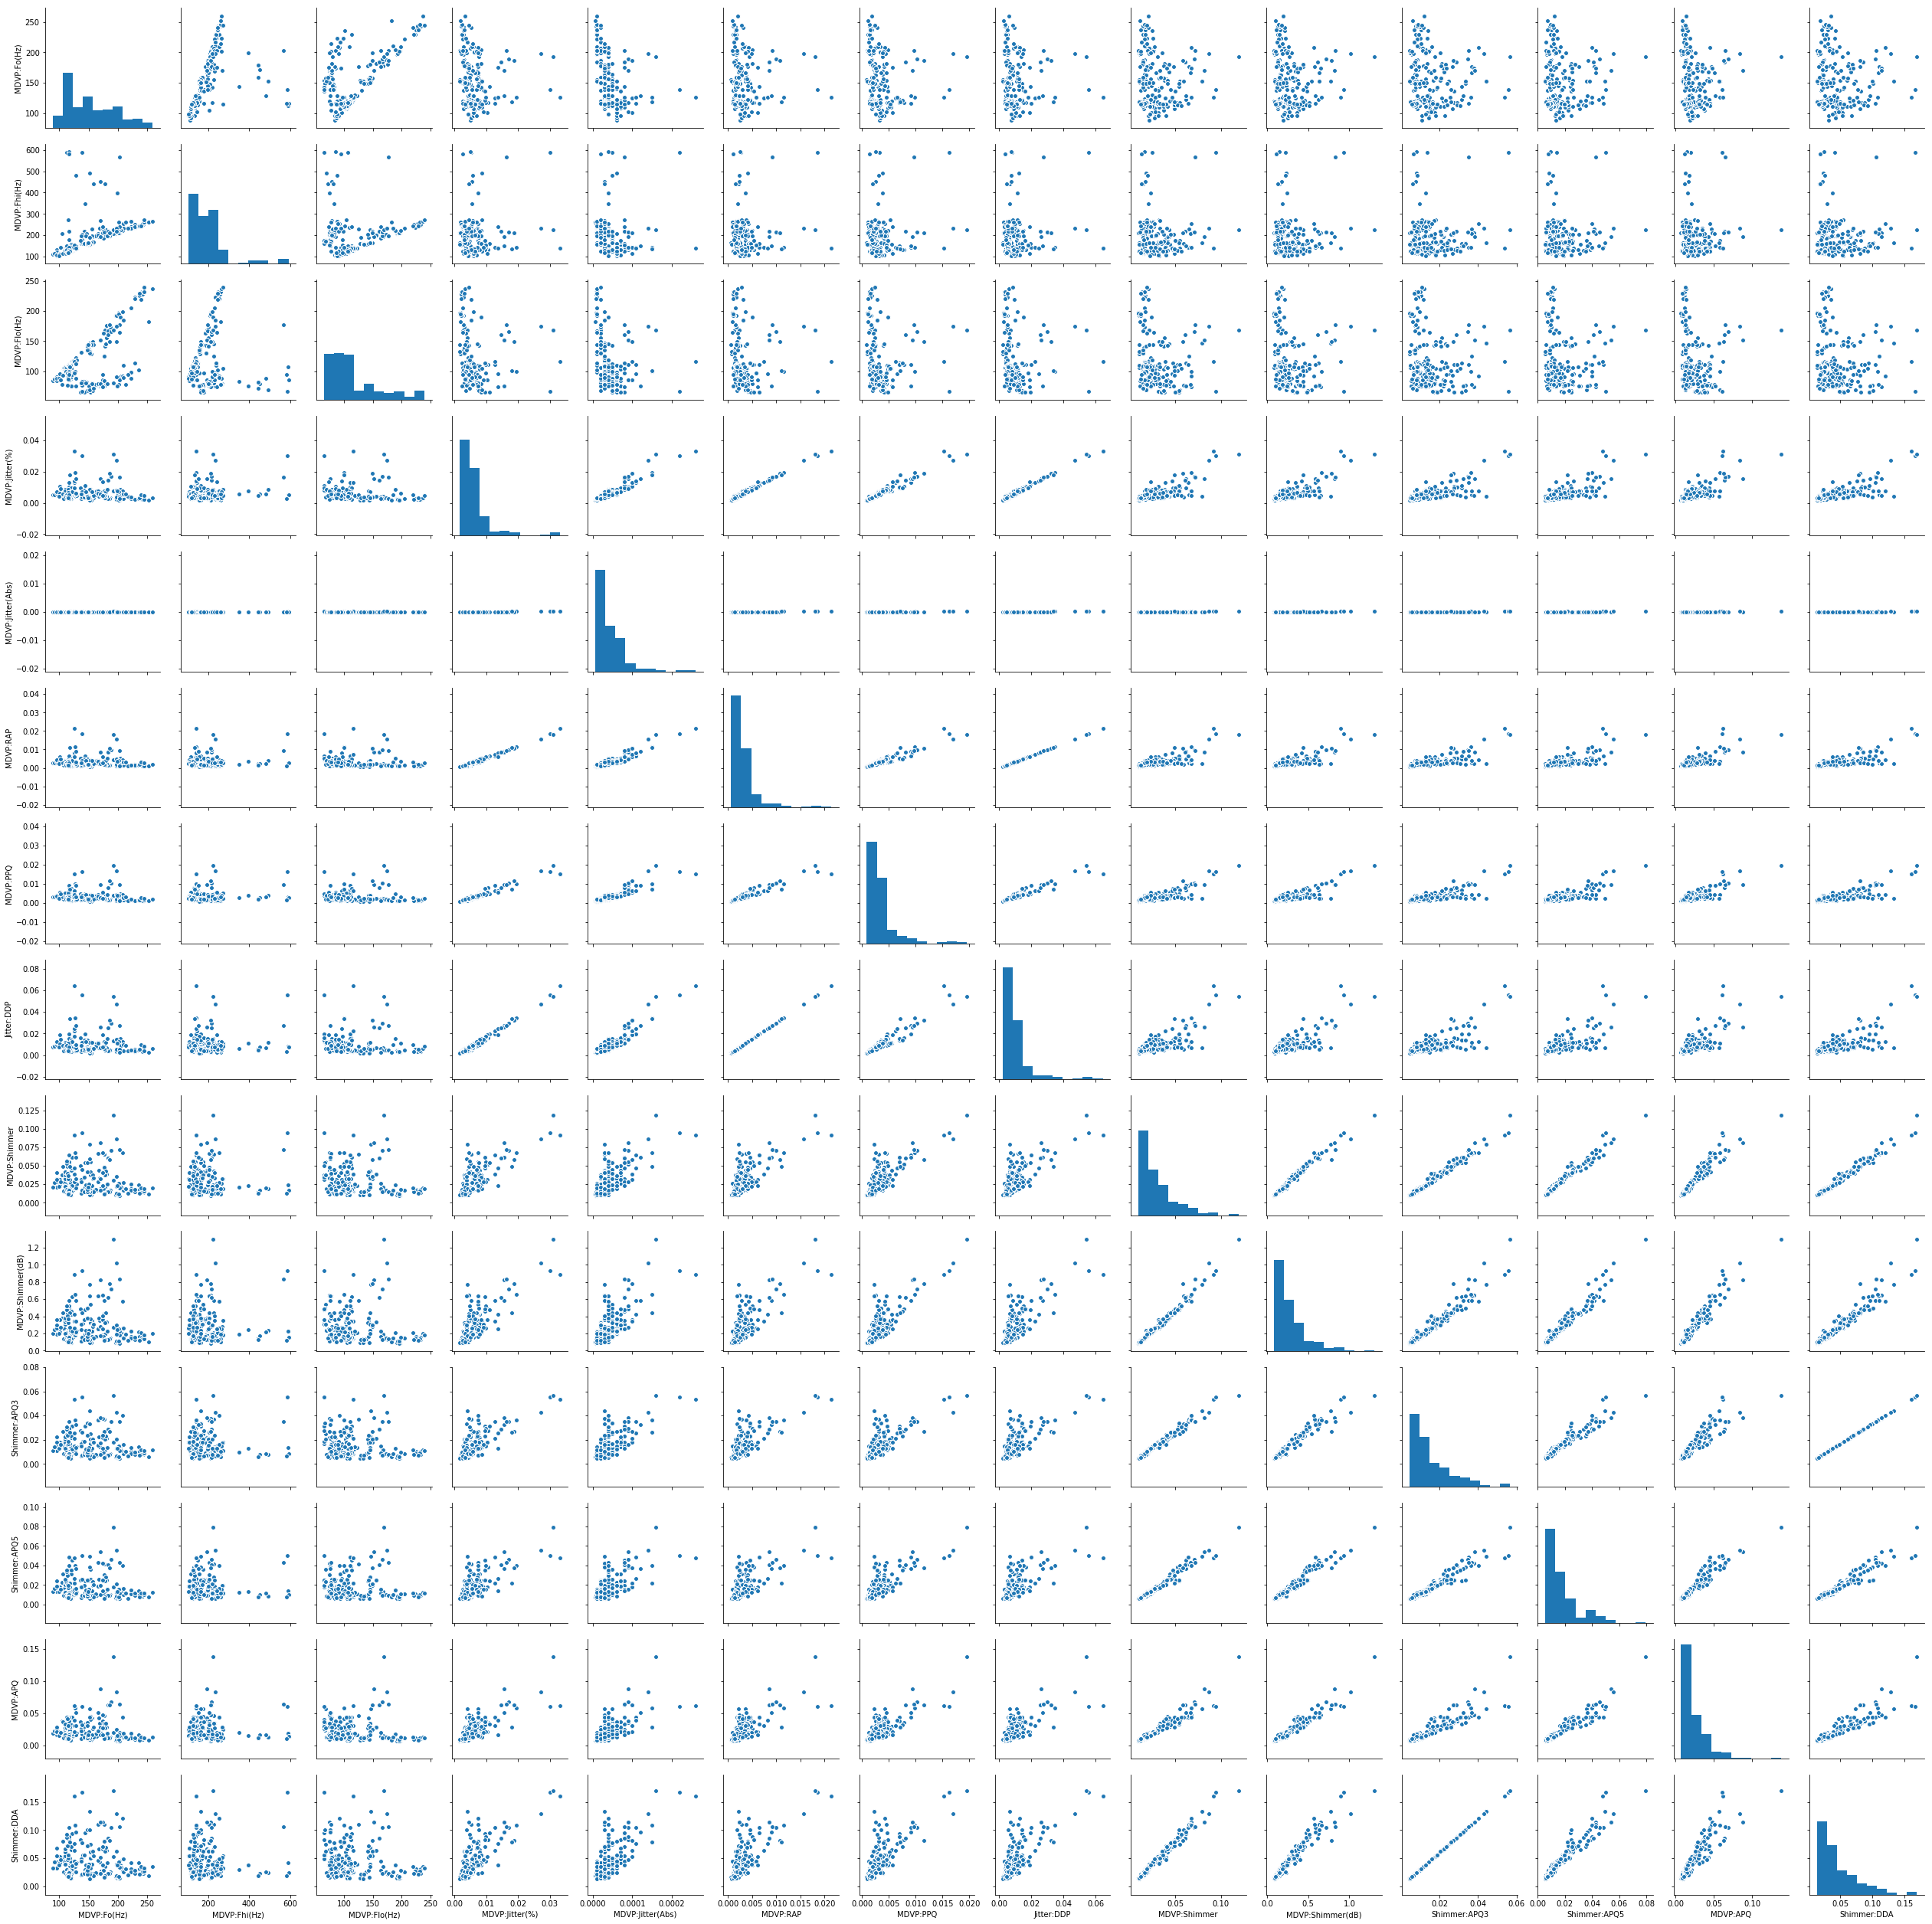

In [42]:
sns.pairplot(Source[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA']])

,Feature,Uniqueness,Positive rel,inverse rel,Pos,Neg,No
0,MDVP:Fo(Hz),20,2,0,"[MDVP:Fo(Hz), MDVP:Flo(Hz)]",[],"[MDVP:Fhi(Hz), MDVP:Jitter(%), MDVP:Jitter(Abs..."
1,MDVP:Fhi(Hz),21,1,0,[MDVP:Fhi(Hz)],[],"[MDVP:Fo(Hz), MDVP:Flo(Hz), MDVP:Jitter(%), MD..."
2,MDVP:Flo(Hz),20,2,0,"[MDVP:Fo(Hz), MDVP:Flo(Hz)]",[],"[MDVP:Fhi(Hz), MDVP:Jitter(%), MDVP:Jitter(Abs..."
3,MDVP:Jitter(%),7,14,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
4,MDVP:Jitter(Abs),7,14,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
5,MDVP:RAP,7,14,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
6,MDVP:PPQ,7,14,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
7,Jitter:DDP,7,14,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
8,MDVP:Shimmer,6,15,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."
9,MDVP:Shimmer(dB),6,15,1,"[MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, M...",[HNR],"[MDVP:Fo(Hz), MDVP:Fhi(Hz), MDVP:Flo(Hz), RPDE..."


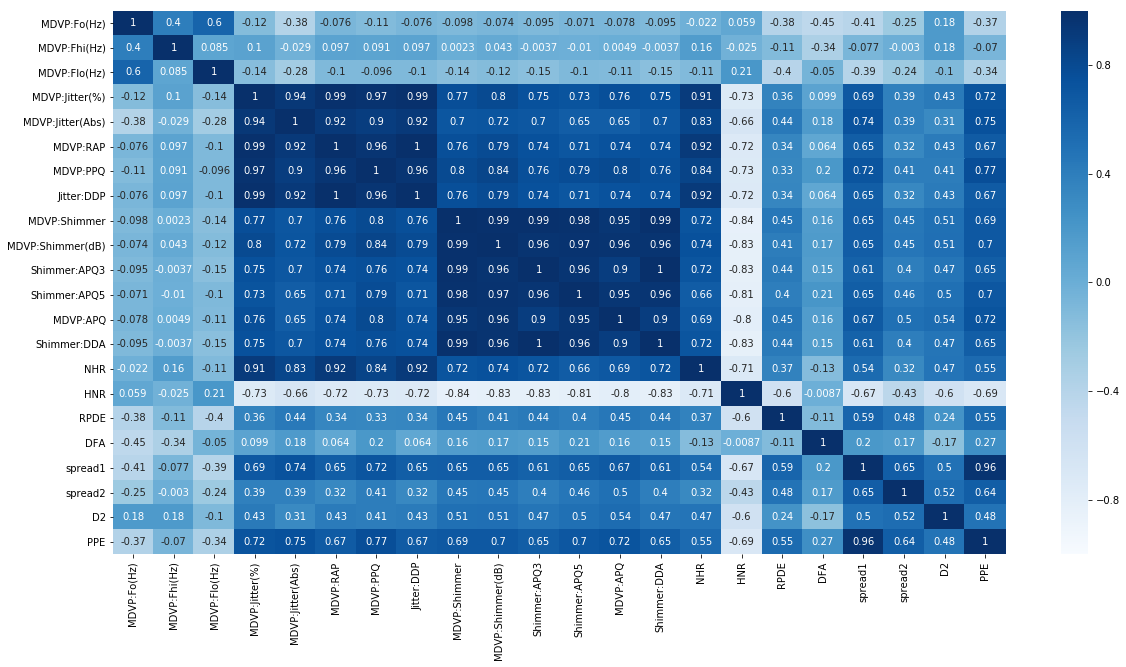

In [43]:
EDA.EDA_Corr(Source)

Correlation Analysis Inference :

1. 7 out of 22 Variables - MDVP:Fhi(Hz), DFA, MDVP:Fo(Hz), MDVP:Flo(Hz)	, RPDE, spread2, D2 have less correlationships with other Xs. This means that they can be 
   potentially a good predictor
2. 14 out of 22 Variables - PPE, spread1, MDVP:APQ, MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ5, MDVP:PPQ, Jitter:DDP, MDVP:RAP, MDVP:Jitter(Abs), Shimmer:APQ3, 
   MDVP:Jitter(%), Shimmer:DDA, NHR are influenced by other variables & each other positively. This means there can be an infleuncing factor compounded may resulting
   in all or some of them being poor predictors. During model building, these will have to be used judiciously
3. HNR is one variable which has inverse relationship with 16 out of remaining 21 variables. This again will have to be used judiciously during model building

In [44]:
x = pandas.DataFrame(Source['MDVP:Fo(Hz)'])

In [45]:
x

,MDVP:Fo(Hz)
0,119.992
1,122.400
2,116.682
3,116.676
4,116.014
5,120.552
6,120.267
7,107.332
8,95.730
9,95.056


TypeError: 'numpy.float64' object cannot be interpreted as an integer

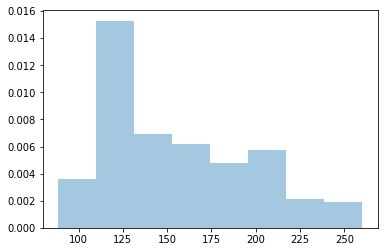

In [46]:
sns.distplot(x)

In [47]:
mean = x.mean()
mean

MDVP:Fo(Hz)    154.228641
dtype: float64

In [48]:
std = x.std()
std

MDVP:Fo(Hz)    41.390065
dtype: float64

In [49]:
z_score = (x-mean)/std

In [50]:
z_score.head()

,MDVP:Fo(Hz)
0,-0.827171
1,-0.768992
2,-0.907141
3,-0.907286
4,-0.923281


TypeError: 'numpy.float64' object cannot be interpreted as an integer

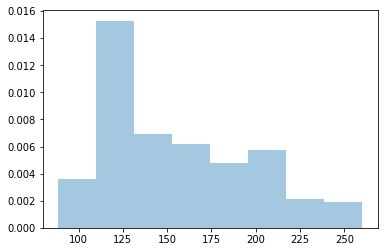

In [51]:
sns.distplot(x)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

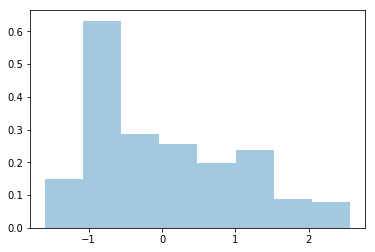

In [52]:
sns.distplot(z_score)

In [53]:
Source.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [54]:
def zscore(x):
    mean = x.mean()
    std = x.std()
    z_score = (x-mean)/std
    return z_score

In [55]:
Subset = Source[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5','MDVP:APQ', 'Shimmer:DDA']]

In [56]:
Subset.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470


In [57]:
(Subset.apply(zscore)).head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA
0,-0.827171,-0.435045,-0.949593,0.334054,0.747835,0.132621,0.758847,0.131417,0.744070,0.737637,0.606298,1.116273,0.332130,0.605972
1,-0.768992,-0.529611,-0.057572,0.713581,1.035010,0.452726,1.273531,0.451521,1.677413,1.763924,1.543937,2.270660,1.156477,1.544279
2,-0.907141,-0.721312,-0.109593,0.882719,1.322186,0.718919,1.581616,0.719960,1.199605,1.024997,1.172625,1.721744,0.697392,1.172305
3,-0.907286,-0.647425,-0.113935,0.773398,1.322186,0.577399,1.280780,0.576194,1.336955,1.204598,1.337105,1.844003,0.804787,1.336788
4,-0.923281,-0.604689,-0.130272,1.365379,1.896537,1.092937,2.041931,1.093977,1.831733,1.548404,1.894567,2.525989,1.213715,1.894585


# Hypothesis Testing

# Approach

1. Test the hypothesis formulated during Exploratory Data Analysis
2. Conclude whether Null to rejected or not

In [58]:
Source.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [59]:
Source.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [60]:
# Perform Anova between first two columns to test whether the variance of the distribution are statistically same or not

1. Null Hypothesis = The variance of distribution between MDVP:Fo(Hz) and MDVP:Fhi(Hz) are same
2. Alternate Hypothesis = There is one or more sample which is not in line with the variance of distribution

In [61]:
sample1 = np.array(Source['MDVP:Fo(Hz)'])
sample2 = np.array(Source['MDVP:Fhi(Hz)'])

In [62]:
sample1

array([119.992, 122.4  , 116.682, 116.676, 116.014, 120.552, 120.267,
       107.332,  95.73 ,  95.056,  88.333,  91.904, 136.926, 139.173,
       152.845, 142.167, 144.188, 168.778, 153.046, 156.405, 153.848,
       153.88 , 167.93 , 173.917, 163.656, 104.4  , 171.041, 146.845,
       155.358, 162.568, 197.076, 199.228, 198.383, 202.266, 203.184,
       201.464, 177.876, 176.17 , 180.198, 187.733, 186.163, 184.055,
       237.226, 241.404, 243.439, 242.852, 245.51 , 252.455, 122.188,
       122.964, 124.445, 126.344, 128.001, 129.336, 108.807, 109.86 ,
       110.417, 117.274, 116.879, 114.847, 209.144, 223.365, 222.236,
       228.832, 229.401, 228.969, 140.341, 136.969, 143.533, 148.09 ,
       142.729, 136.358, 120.08 , 112.014, 110.793, 110.707, 112.876,
       110.568,  95.385, 100.77 ,  96.106,  95.605, 100.96 ,  98.804,
       176.858, 180.978, 178.222, 176.281, 173.898, 179.711, 166.605,
       151.955, 148.272, 152.125, 157.821, 157.447, 159.116, 125.036,
       125.791, 126.

In [63]:
f, p = f_oneway(sample1, sample2)
 
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

One-way ANOVA
F value: 35.55025886274977
P value: 5.593246321541941e-09 



In [64]:
p < 0.05

True

In [65]:
# Perform one sample t-test for 'MDVP:Fo(Hz)'

#Null Hypothesis = Mean of 'MDVP:Fo(Hz)' for a new set of data in production is going to be the same 'MDVP:Fo(Hz)'.mean()
#Alternate Hypothesis = There is atleast one set of data in production where the mean is going to be different

In [66]:
sample1

array([119.992, 122.4  , 116.682, 116.676, 116.014, 120.552, 120.267,
       107.332,  95.73 ,  95.056,  88.333,  91.904, 136.926, 139.173,
       152.845, 142.167, 144.188, 168.778, 153.046, 156.405, 153.848,
       153.88 , 167.93 , 173.917, 163.656, 104.4  , 171.041, 146.845,
       155.358, 162.568, 197.076, 199.228, 198.383, 202.266, 203.184,
       201.464, 177.876, 176.17 , 180.198, 187.733, 186.163, 184.055,
       237.226, 241.404, 243.439, 242.852, 245.51 , 252.455, 122.188,
       122.964, 124.445, 126.344, 128.001, 129.336, 108.807, 109.86 ,
       110.417, 117.274, 116.879, 114.847, 209.144, 223.365, 222.236,
       228.832, 229.401, 228.969, 140.341, 136.969, 143.533, 148.09 ,
       142.729, 136.358, 120.08 , 112.014, 110.793, 110.707, 112.876,
       110.568,  95.385, 100.77 ,  96.106,  95.605, 100.96 ,  98.804,
       176.858, 180.978, 178.222, 176.281, 173.898, 179.711, 166.605,
       151.955, 148.272, 152.125, 157.821, 157.447, 159.116, 125.036,
       125.791, 126.

In [67]:
from scipy.stats import ttest_1samp
t_statistic, p_value = ttest_1samp(sample1, sample1.mean())
print(t_statistic,p_value)

0.0 1.0


In [68]:
Sign_value = 0.05

In [69]:
p_value < 0.05

False

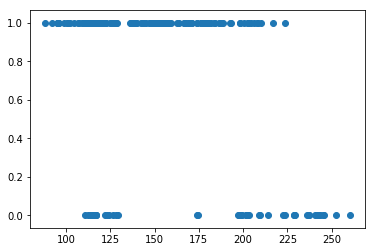

In [70]:
matplot.scatter(Source['MDVP:Fo(Hz)'],Source['status'])

# Build a Logistic Regression Model

In [71]:
Source.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [72]:
Source.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [73]:
Y = Source['status']

In [74]:
X = Source[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE']]

In [75]:
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [76]:
Y[0:5]

0    1
1    1
2    1
3    1
4    1
Name: status, dtype: category
Categories (2, int64): [0, 1]

In [77]:
Source['status'][0:5]

0    1
1    1
2    1
3    1
4    1
Name: status, dtype: category
Categories (2, int64): [0, 1]

In [78]:
X.shape

(195, 22)

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=100)

In [80]:
X_train.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
185,116.286,177.291,96.983,0.00314,0.00003,0.00134,0.00192,0.00403,0.01564,0.136,...,0.01691,0.02001,0.00737,24.199,0.598515,0.654331,-5.592584,0.133917,2.058658,0.214346
26,171.041,208.313,75.501,0.00455,0.00003,0.00250,0.00234,0.00750,0.01966,0.186,...,0.01872,0.02666,0.01095,25.908,0.418622,0.720916,-6.183590,0.226278,2.589702,0.147403
120,128.940,479.697,88.251,0.00581,0.00005,0.00241,0.00314,0.00723,0.02008,0.221,...,0.01734,0.02548,0.02350,24.743,0.487756,0.684130,-6.186128,0.279933,2.686240,0.152428
123,182.018,197.173,79.187,0.00842,0.00005,0.00506,0.00449,0.01517,0.02503,0.231,...,0.01931,0.04115,0.01813,18.784,0.589956,0.732903,-5.445140,0.142466,2.174306,0.215558


In [81]:
Y_train

3      1
185    0
26     1
120    1
123    1
77     1
134    1
170    0
57     1
44     0
178    1
112    1
85     1
194    0
10     1
20     1
160    1
12     1
16     1
97     1
169    0
45     0
173    0
128    1
179    1
182    1
187    0
51     0
39     1
110    1
      ..
129    1
159    1
132    1
108    1
155    1
130    1
86     1
93     1
137    1
144    1
58     1
60     0
107    1
143    1
193    0
34     0
14     1
66     1
53     0
98     1
180    1
94     1
138    1
176    0
79     1
87     1
103    1
67     1
24     1
8      1
Name: status, Length: 136, dtype: category
Categories (2, int64): [0, 1]

In [82]:
logmodel = LogisticRegression()

In [83]:
Logistic_Reg_Model = logmodel.fit(X_train,Y_train)

In [84]:
Logistic_Reg_Model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
predictions = Logistic_Reg_Model.predict(X_test)

In [86]:
predictions

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [87]:
Y_test

164    1
188    0
146    1
126    1
151    1
92     1
153    1
177    1
116    1
31     0
64     0
115    1
168    0
158    1
162    1
149    1
191    0
133    1
11     1
165    0
15     1
190    0
172    0
124    1
82     1
99     1
89     1
90     1
125    1
150    1
189    0
59     1
41     1
73     1
32     0
46     0
157    1
81     1
96     1
119    1
154    1
88     1
7      1
104    1
69     1
28     1
29     1
83     1
40     1
148    1
111    1
163    1
75     1
1      1
74     1
131    1
65     0
156    1
122    1
Name: status, dtype: category
Categories (2, int64): [0, 1]

# Evaluate Logistic Regression Model

In [88]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.89      0.89      0.89        47

    accuracy                           0.83        59
   macro avg       0.74      0.74      0.74        59
weighted avg       0.83      0.83      0.83        59



In [89]:
confusion_matrix(Y_test,predictions)

array([[ 7,  5],
       [ 5, 42]], dtype=int64)

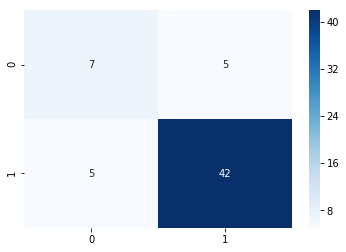

In [90]:
sns.heatmap(confusion_matrix(Y_test,predictions), annot=True, cmap='Blues',fmt='g')

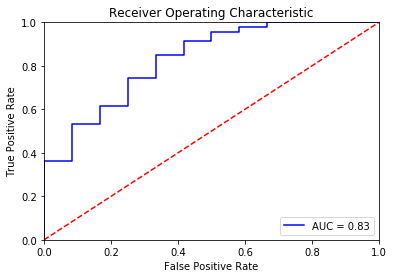

In [91]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = Logistic_Reg_Model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
Logistic_Accuracy = accuracy_score(Y_test,predictions)
Logistic_Accuracy

0.8305084745762712

In [93]:
Logistic_Gini = 2*roc_auc - 1
Logistic_Gini

0.6595744680851063

In [94]:
Logistic_AUC = roc_auc
Logistic_AUC

0.8297872340425532

# Naive Bayes - Gaussian

In [95]:
Naive = GaussianNB()

In [96]:
Naive_model = Naive.fit(X_train,Y_train)

In [97]:
Naive_model

GaussianNB(priors=None, var_smoothing=1e-09)

In [98]:
Naive_predictions = Naive_model.predict(X_test)

In [99]:
Naive_predictions

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int64)

# Naive Bayes Evaluation

In [100]:
print(classification_report(Y_test,Naive_predictions))

              precision    recall  f1-score   support

           0       0.33      0.75      0.46        12
           1       0.91      0.62      0.73        47

    accuracy                           0.64        59
   macro avg       0.62      0.68      0.60        59
weighted avg       0.79      0.64      0.68        59



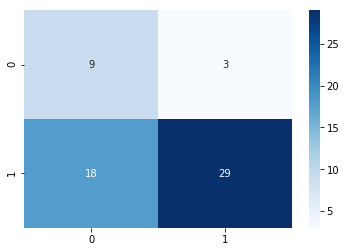

In [101]:
sns.heatmap(confusion_matrix(Y_test,Naive_predictions), annot=True, cmap='Blues',fmt='g')

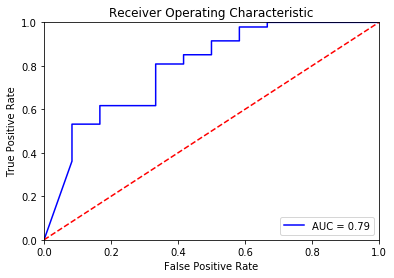

In [102]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = Naive_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
Naive_Accuracy = accuracy_score(Y_test,Naive_predictions)
Naive_Accuracy

0.6440677966101694

In [104]:
Naive_Gini = 2*roc_auc - 1
Naive_Gini

0.5833333333333333

In [105]:
Naive_AUC = roc_auc
Naive_AUC

0.7916666666666666

# KNN Classifier

In [106]:
KNN = KNeighborsClassifier()

In [107]:
KNN_model = KNN.fit(X_train,Y_train)

In [108]:
KNN_predictions = KNN_model.predict(X_test)

In [109]:
KNN_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [110]:
# Choosing N-Neighbors hyper parameter

In [111]:
N = [3,5,7,9,11,13,15,17,19,21,23,25,27,29]

In [112]:
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in N:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    # predict the response
    y_pred = knn.predict(X_test)
    # evaluate accuracy
    scores = accuracy_score(Y_test, y_pred)
    ac_scores.append(scores)


In [113]:
pandas.DataFrame(ac_scores,N)

,0
3,0.830508
5,0.847458
7,0.830508
9,0.830508
11,0.796610
13,0.813559
15,0.796610
17,0.796610
19,0.796610
21,0.796610


In [114]:
Dist = [1,2]
ac_scores = []


for k in Dist:
    knn = KNeighborsClassifier(n_neighbors=5,p=k)
    knn.fit(X_train, Y_train)
    # predict the response
    y_pred = knn.predict(X_test)
    # evaluate accuracy
    scores = accuracy_score(Y_test, y_pred)
    ac_scores.append(scores)


In [115]:
pandas.DataFrame(ac_scores,Dist)

,0
1,0.830508
2,0.847458


In [116]:
KNN = KNeighborsClassifier(n_neighbors=5,p=2)

In [117]:
KNN_model = KNN.fit(X_train,Y_train)

In [118]:
KNN_predictions = KNN_model.predict(X_test)

In [119]:
KNN_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# KNN Evaluation

In [120]:
print(classification_report(Y_test,KNN_predictions))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.88      0.94      0.91        47

    accuracy                           0.85        59
   macro avg       0.77      0.72      0.74        59
weighted avg       0.84      0.85      0.84        59



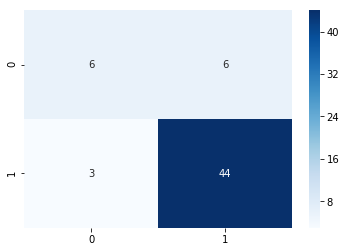

In [121]:
sns.heatmap(confusion_matrix(Y_test,KNN_predictions), annot=True, cmap='Blues',fmt='g')

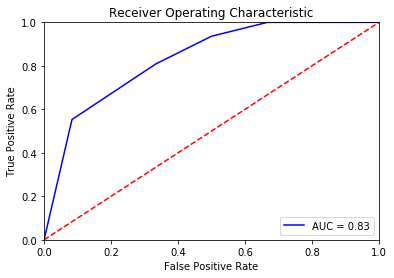

In [122]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = KNN_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [123]:
KNN_Accuracy = accuracy_score(Y_test,KNN_predictions)
KNN_Accuracy

0.847457627118644

In [124]:
KNN_Gini = 2*roc_auc - 1
KNN_Gini

0.6666666666666667

In [125]:
KNN_AUC = roc_auc
KNN_AUC

0.8333333333333334

# Support Vector Classifier - Linear Kernel

In [126]:
SVM_Model = svm.SVC(kernel = 'linear', C = 100, probability=True)

In [127]:
SVM_Model.fit(X_train,Y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [128]:
SVM_Predictions = SVM_Model.predict(X_test)

In [129]:
SVM_Predictions

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

# SVM Evaluation

In [130]:
print(classification_report(Y_test,SVM_Predictions))

              precision    recall  f1-score   support

           0       0.40      0.67      0.50        12
           1       0.90      0.74      0.81        47

    accuracy                           0.73        59
   macro avg       0.65      0.71      0.66        59
weighted avg       0.80      0.73      0.75        59



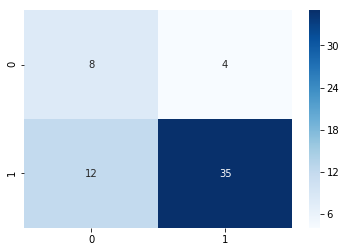

In [131]:
sns.heatmap(confusion_matrix(Y_test,SVM_Predictions), annot=True, cmap='Blues',fmt='g')

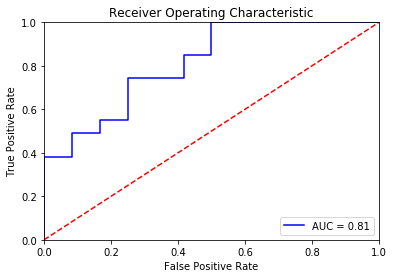

In [132]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = SVM_Model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [133]:
SVM_Accuracy_Linear = accuracy_score(Y_test,SVM_Predictions)
SVM_Accuracy_Linear

0.7288135593220338

In [134]:
SVM_Gini_Linear = 2*roc_auc - 1
SVM_Gini_Linear

0.6276595744680851

In [135]:
SVM_AUC_Linear = roc_auc
SVM_AUC_Linear

0.8138297872340425

# Support Vector Classifier - RBF Kernel

In [136]:
SVM_Model = svm.SVC(kernel = 'rbf', C = 100, probability=True)
SVM_Model.fit(X_train,Y_train)
SVM_Predictions = SVM_Model.predict(X_test)
SVM_Predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [137]:
print(classification_report(Y_test,SVM_Predictions))

              precision    recall  f1-score   support

           0       0.57      0.33      0.42        12
           1       0.85      0.94      0.89        47

    accuracy                           0.81        59
   macro avg       0.71      0.63      0.65        59
weighted avg       0.79      0.81      0.79        59



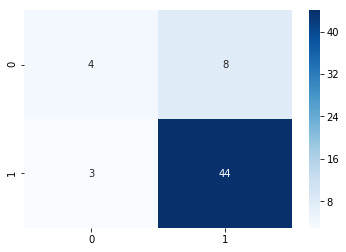

In [138]:
sns.heatmap(confusion_matrix(Y_test,SVM_Predictions), annot=True, cmap='Blues',fmt='g')

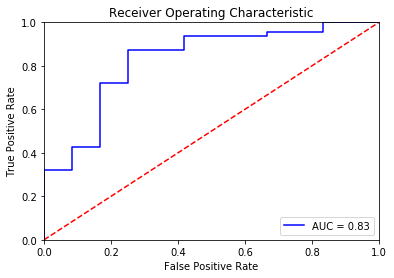

In [139]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = SVM_Model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [140]:
SVM_Accuracy_RBF = accuracy_score(Y_test,SVM_Predictions)
SVM_Accuracy_RBF

0.8135593220338984

In [141]:
SVM_Gini_RBF = 2*roc_auc - 1
SVM_Gini_RBF

0.6560283687943262

In [142]:
SVM_AUC_RBF = roc_auc
SVM_AUC_RBF

0.8280141843971631

# Comparing models

In [143]:
Compare = [[Logistic_Accuracy,Logistic_Gini,Logistic_AUC],
           [Naive_Accuracy,Naive_Gini,Naive_AUC],[KNN_Accuracy,KNN_Gini,KNN_AUC],
            [SVM_Accuracy_Linear,SVM_Gini_Linear,SVM_AUC_Linear], [SVM_Accuracy_RBF,SVM_Gini_RBF,SVM_AUC_RBF]]

In [144]:
pandas.DataFrame(Compare, columns= ['Accuracy','Gini Index', 'AUC'], index=['Logistic','Naive','KNN','SVM_Linear','SVM_RBF'])

,Accuracy,Gini Index,AUC
Logistic,0.830508,0.659574,0.829787
Naive,0.644068,0.583333,0.791667
KNN,0.847458,0.666667,0.833333
SVM_Linear,0.728814,0.627660,0.813830
SVM_RBF,0.813559,0.656028,0.828014


# Build Decision Tree Model

In [145]:
target_names = ['Yes','No']

                       Imp
MDVP:Fo(Hz)       0.000000
MDVP:Fhi(Hz)      0.063667
MDVP:Flo(Hz)      0.000000
MDVP:Jitter(%)    0.000000
MDVP:Jitter(Abs)  0.067729
MDVP:RAP          0.000000
MDVP:PPQ          0.000000
Jitter:DDP        0.000000
MDVP:Shimmer      0.000000
MDVP:Shimmer(dB)  0.000000
Shimmer:APQ3      0.000000
Shimmer:APQ5      0.382673
MDVP:APQ          0.000000
Shimmer:DDA       0.036290
NHR               0.120287
HNR               0.000000
RPDE              0.000000
DFA               0.000000
spread1           0.047878
spread2           0.000000
D2                0.097573
PPE               0.183903


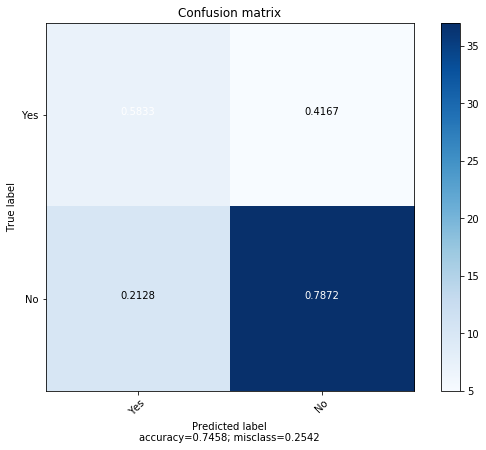

              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.88      0.79      0.83        47

    accuracy                           0.75        59
   macro avg       0.65      0.69      0.66        59
weighted avg       0.79      0.75      0.76        59



,Model_Performance_All
Accuracy,0.745763
Recall,0.787234
Precision,0.880952
f1_Score,0.831461


In [146]:
dt_model = DecisionTreeClassifier(criterion = 'entropy' )
# Build model
dt_model.fit(X_train, Y_train)

Parkinsons_Tree_File = open('Parkinsons_Demo.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file=Parkinsons_Tree_File, feature_names = list(X_train), class_names = list(target_names))
Parkinsons_Tree_File.close()

print (pandas.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))
Y_predict = dt_model.predict(X_test)

dt_model_all = plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True)
dt_model_all = dt_model_all.rename(columns={"Model_Performance" : "Model_Performance_All" })
dt_model_all

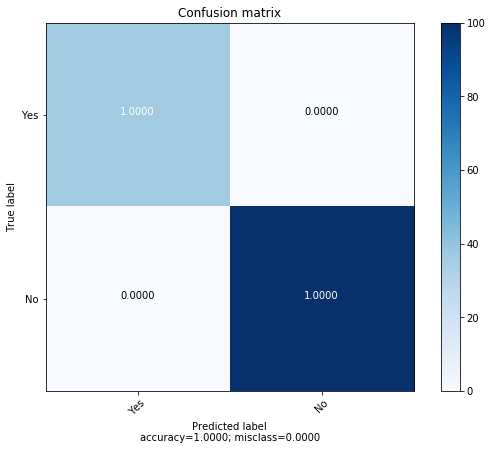

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00       100

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136



,Model_Performance_All
Accuracy,1.0
Recall,1.0
Precision,1.0
f1_Score,1.0


In [147]:
Y_predict = dt_model.predict(X_train)

dt_model_all = plot_confusion_matrix(Y_train,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True)
dt_model_all = dt_model_all.rename(columns={"Model_Performance" : "Model_Performance_All" })
dt_model_all

# Regularization of Decision Tree Models

In [148]:
RandomState = numpy.random.seed(1234)
Test_reg_scores = []
max_depth = []
max_leaf_nodes = []
for i in range(1,20,2):
    for j in range(2,20,1):
        Test_reg_param = DecisionTreeClassifier(criterion = 'entropy', max_depth = i, max_leaf_nodes = j, random_state=RandomState )
        Test_reg_param.fit(X_train, Y_train)
        Y_predict_Test_reg = Test_reg_param.predict(X_test)
        scores = Test_reg_param.score(X_test, Y_test)
        Test_reg_scores.append(scores)
        max_depth.append(i)
        max_leaf_nodes.append(j)

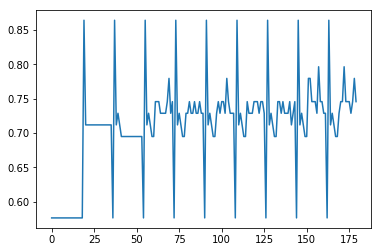

In [149]:
matplot.plot(Test_reg_scores)

In [150]:
pandas.concat([pandas.DataFrame(Test_reg_scores, columns = ['Scores']),
               pandas.DataFrame(max_depth, columns = ['max_depth']),
               pandas.DataFrame(max_leaf_nodes, columns = ['max_leaf_nodes'])], axis = 1)

,Scores,max_depth,max_leaf_nodes
0,0.576271,1,2
1,0.576271,1,3
2,0.576271,1,4
3,0.576271,1,5
4,0.576271,1,6
5,0.576271,1,7
6,0.576271,1,8
7,0.576271,1,9
8,0.576271,1,10
9,0.576271,1,11


                       Imp
MDVP:Fo(Hz)       0.000000
MDVP:Fhi(Hz)      0.063667
MDVP:Flo(Hz)      0.000000
MDVP:Jitter(%)    0.000000
MDVP:Jitter(Abs)  0.067729
MDVP:RAP          0.000000
MDVP:PPQ          0.000000
Jitter:DDP        0.000000
MDVP:Shimmer      0.000000
MDVP:Shimmer(dB)  0.000000
Shimmer:APQ3      0.000000
Shimmer:APQ5      0.382673
MDVP:APQ          0.000000
Shimmer:DDA       0.036290
NHR               0.120287
HNR               0.000000
RPDE              0.000000
DFA               0.000000
spread1           0.047878
spread2           0.000000
D2                0.097573
PPE               0.183903


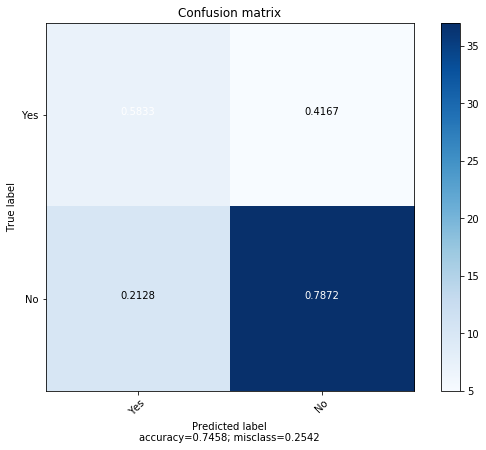

              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.88      0.79      0.83        47

    accuracy                           0.75        59
   macro avg       0.65      0.69      0.66        59
weighted avg       0.79      0.75      0.76        59



,Model_Performance_All
Accuracy,1.0
Recall,1.0
Precision,1.0
f1_Score,1.0


In [151]:
dt_model_all_reg = DecisionTreeClassifier(criterion = 'entropy', max_depth=1, max_leaf_nodes= 8 )
# Build model
dt_model_all_reg.fit(X_train, Y_train)

Parkinsons_Tree_File = open('Parkinsons_Demo_reg.dot','w')
dot_data = tree.export_graphviz(dt_model_all_reg, out_file=Parkinsons_Tree_File, feature_names = list(X_train), class_names = list(target_names))
Parkinsons_Tree_File.close()

print (pandas.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))
Y_predict = dt_model.predict(X_test)

dt_model_all_reg = plot_confusion_matrix(Y_test,Y_predict, target_names,title='Confusion matrix',cmap=None,normalize=True)
dt_model_all_reg = dt_model_all.rename(columns={"Model_Performance" : "Model_Performance_All" })
dt_model_all_reg

# Regularize Decision Tree using Grid Search and Cross Validation

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
                       Imp
MDVP:Fo(Hz)       0.000000
MDVP:Fhi(Hz)      0.063667
MDVP:Flo(Hz)      0.000000
MDVP:Jitter(%)    0.000000
MDVP:Jitter(Abs)  0.067729
MDVP:RAP          0.000000
MDVP:PPQ          0.000000
Jitter:DDP        0.000000
MDVP:Shimmer      0.000000
MDVP:Shimmer(dB)  0.000000
Shimmer:APQ3      0.036290
Shimmer:APQ5      0.382673
MDVP:APQ          0.052914
Shimmer:DDA       0.000000
NHR               0.067373
HNR               0.000000
RPDE              0.000000
DFA               0.000000
spread1           0.000000
spread2           0.000000
D2      

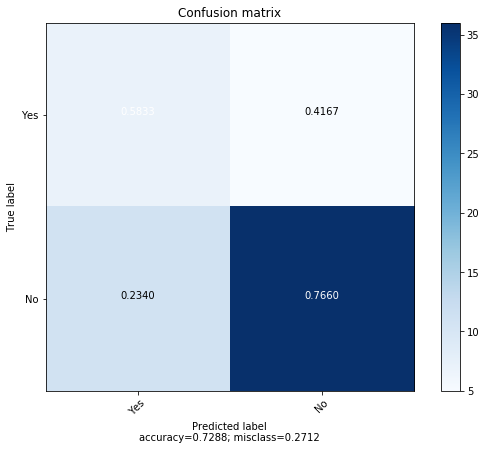

              precision    recall  f1-score   support

           0       0.39      0.58      0.47        12
           1       0.88      0.77      0.82        47

    accuracy                           0.73        59
   macro avg       0.63      0.67      0.64        59
weighted avg       0.78      0.73      0.75        59



ValueError: too many values to unpack (expected 4)

In [152]:
D,L,Param,DT_Reg_Model = Build_Model.GS_DT(X_train,X_test,Y_train,Y_test,max_depth_start=4, max_depth_end=10, max_depth_jump=1,max_leaf_nodes_start=3,max_leaf_nodes_end=20,max_leaf_nodes_jump=1,cv_count=10,target_names=target_names)

In [ ]:
DT_Predictions = DT_Reg_Model.predict(X_test)
DT_Predictions

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = DT_Reg_Model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
DT_Accuracy = accuracy_score(Y_test,DT_Predictions)
DT_Accuracy

In [ ]:
DT_Gini = 2*roc_auc - 1
DT_Gini

In [ ]:
DT_AUC = roc_auc
DT_AUC

# Build Random Forest model using GridSearch and Cross Validation

In [24]:
estimators, model, RF_Model = Build_Model.GS_RandomForest(X_train,Y_train,X_test,Y_test, n_estimator_start = 100, n_estimator_end = 1000, n_estimator_jump = 50,cv_count = 10, target_names=target_names)

NameError: name 'X_train' is not defined

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification

# Firstly, calculate the probabilities of predictions made
probs = RF_Model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
metrics
# method to plot
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0,1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
RF_Predictions = RF_Model.predict(X_test)
RF_Predictions

In [ ]:
RF_Accuracy = accuracy_score(Y_test,RF_Predictions)
RF_Accuracy

In [25]:
RF_Gini = 2*roc_auc - 1
RF_Gini

NameError: name 'roc_auc' is not defined

In [ ]:
RF_AUC = roc_auc
RF_AUC

# Compare Models

In [ ]:
Compare = [[Logistic_Accuracy,Logistic_Gini,Logistic_AUC],
           [Naive_Accuracy,Naive_Gini,Naive_AUC],[KNN_Accuracy,KNN_Gini,KNN_AUC],
            [SVM_Accuracy_Linear,SVM_Gini_Linear,SVM_AUC_Linear], [SVM_Accuracy_RBF,SVM_Gini_RBF,SVM_AUC_RBF],
          [DT_Accuracy,DT_Gini,DT_AUC], [RF_Accuracy,RF_Gini,RF_AUC]]

In [26]:
pandas.DataFrame(Compare, columns= ['Accuracy','Gini Index', 'AUC'], index=['Logistic','Naive','KNN','SVM_Linear','SVM_RBF','DT_Reg',
                                                                           'RF'])

NameError: name 'Compare' is not defined

# Unsupervised Learning - Kmeans, Hierarchical, PCA etc

In [ ]:
Subset

In [ ]:
Subset = (Subset.apply(zscore))

In [27]:
Subset.head()

NameError: name 'Subset' is not defined

# Finding clusters using KMeans

In [ ]:
cluster_range = range( 1, 10)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(Subset)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
  


# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pandas.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:15]

In [ ]:
matplot.figure(figsize=(12,6))
matplot.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [28]:
X = Subset
range_n_clusters = [2, 3, 4,5,6]

for n_clusters in range_n_clusters:
    fig, (ax1) = matplot.subplots(1)
    fig.set_size_inches(12, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(numpy.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="blue", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

matplot.show()

NameError: name 'Subset' is not defined

In [29]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(Subset)
labels = kmeans.predict(Subset)
centroids = kmeans.cluster_centers_
print("Centroid values")
print(centroids)

NameError: name 'Subset' is not defined

In [ ]:
prediction= kmeans.predict(Subset)
Subset["clusters"] = prediction

In [ ]:
Subset.head()

In [ ]:
Subset['clusters'].value_counts()

In [ ]:
pandas.DataFrame(centroids)

In [ ]:
(Subset).boxplot(by = 'clusters', figsize=(25,50), layout=(5,3))